In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
from numpy import log
import shutil
import sys
import os.path
#from pyomo.environ import *
import pyomo.environ as pe
import pyomo.opt as po

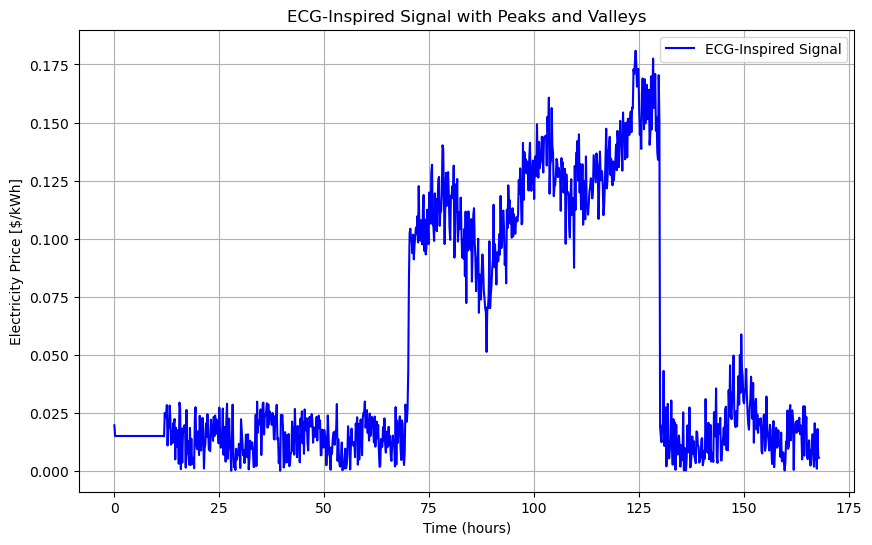

In [2]:
# Generate time values from 0 to 168 hours with 10-minute intervals
total_hours = 168
interval_minutes = 10
interval_hours = interval_minutes / 60
time_values = np.arange(0, total_hours, interval_hours)
time_indices = set(range(1, len(time_values) + 1))

# Generate a sinusoidal function for a regular pattern
regular_pattern = 0.02 * np.sin(2 * np.pi * time_values / 24)

# Add random noise for irregularities (peaks and valleys)
irregularities = np.random.normal(0, 0.01, len(time_values))

# Set average values for different time intervals
average_values = np.zeros_like(time_values)
average_values[(time_values >= 1) & (time_values < 70)] = 0.03
average_values[(time_values >= 70) & (time_values < 90)] = 0.098
average_values[(time_values >= 90) & (time_values < 110)] = 0.115
average_values[(time_values >= 110) & (time_values < 130)] = 0.14
average_values[(time_values >= 130) & (time_values < 150)] = 0.013
average_values[(time_values >= 150) & (time_values < 160)] = 0.0120

# Create the ECG-inspired signal with specified averages
ecg_signal = regular_pattern + irregularities + average_values

# Apply conditions
for i in time_indices:
    if ecg_signal[i-1] < 0:
        ecg_signal[i-1] = -ecg_signal[i-1]

for i in time_indices:
    if time_values[i-1] < 70 and ecg_signal[i] > 0.030:
        ecg_signal[i] = ecg_signal[i] - 0.055

for i in range(1, 71):
    ecg_signal[i] = 0.015

# Add offset
ecg_signal = ecg_signal +0
for i in time_indices:
    if ecg_signal[i-1] < 0:
        ecg_signal[i-1] = -ecg_signal[i-1]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(time_values, ecg_signal, label='ECG-Inspired Signal', color='blue')

# Set plot labels and title
plt.xlabel('Time (hours)')
plt.ylabel('Electricity Price [$/kWh]')
plt.title('ECG-Inspired Signal with Peaks and Valleys')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

######## ##########################################################################################


In [3]:
m = pe.ConcreteModel()

## Defined Sets:

> Modes
#### M = {'ST', 'OD', 'CleanSTOD', 'CleanODST'}

> Active Modes
#### Mac = {'ST','OD'}              


In [4]:

# Defining Sets and Data

#Sets
M = {'ST','OD','CleanSTOD','CleanODST'}
Mac = {'ST','OD'}                            #### Active Mode set
Mcl = {'CleanSTOD','CleanODST'}              #### Clean Mode set
T = set(range(1, len(time_values) + 1))
C = {'H2','O2','NaCl'}      # Cl_2 not included, defined separately wherever needed.
E = set(range(1, 3))                         #(index e) the set of linearization intervals of the linearized electricity demand

#Data for parameters
a = {
    ('ST',1):2547.33/1000,
    ('ST',2):2968.667/1000,
    ('OD',1):1747.43/1000,
    ('OD',2):2189.33/1000
}

b = {
    ('ST',1):992.6,
    ('ST',2):1756.8,
    ('OD',1):607.37,
    ('OD',2):1131.6,
}
    
# lower and upper bounds of the Cl2 production rates of each linearization interval e, kg/s
mDot_le = {
    1:0.5*1000/3600,
    2:0.8*1000/3600,
}

mDot_he = {
    1:0.8*1000/3600,
    2:1.1*1000/3600,
}
 
M_C = {        # molar mass of each component C, g/mol
    'H2':2/1000,
    'O2':32/1000,
    'NaCl':58.443/1000,
}

p_C = {        # specific prices for each component C, $/kg
    'H2':2,
    'O2':0.05,
    'NaCl':0.04,
}

El_p_dict = dict(zip(range(1, len(ecg_signal) + 1), ecg_signal))

theta_trans = {
    ('ST','CleanSTOD'):1,
    ('OD','CleanODST'):1,
    ('CleanODST','ST'):36,
    ('CleanSTOD','OD'):36,
}
     

# Initializing Sets
m.M = pe.Set(initialize=M)
m.T = pe.Set(initialize=T)
m.C = pe.Set(initialize=C)
m.E = pe.Set(initialize=E)

m.Mac = pe.Set(initialize=Mac)
m.Mcl = pe.Set(initialize=Mcl)


# Time steps used for ramping
T_ramp = set(range(1, len(time_values)))
m.T_ramp = pe.Set(initialize=T_ramp)

# Time steps used for Transition
T_trans = set(range(2, len(time_values) + 1))
m.T_trans = pe.Set(initialize=T_trans)

# Time steps used for Min Time for mode assurance
T_minassure = set(range(-35, len(time_values) + 1))
m.T_minassure = pe.Set(initialize=T_minassure)

(type: set).  This WILL potentially lead to nondeterministic behavior in Pyomo
(type: set).  This WILL potentially lead to nondeterministic behavior in Pyomo
(type: set).  This WILL potentially lead to nondeterministic behavior in Pyomo
(type: set).  This WILL potentially lead to nondeterministic behavior in Pyomo
source (type: set).  This WILL potentially lead to nondeterministic behavior
in Pyomo
source (type: set).  This WILL potentially lead to nondeterministic behavior
in Pyomo
source (type: set).  This WILL potentially lead to nondeterministic behavior
in Pyomo
source (type: set).  This WILL potentially lead to nondeterministic behavior
in Pyomo
data source (type: set).  This WILL potentially lead to nondeterministic
behavior in Pyomo


In [5]:
# Initializing Parameters

     ### Indexed Params ###

# Define parameter a : a->m,e
m.a = pe.Param(m.M,m.E,initialize=a,default=0)     # can default be set to 0? think yes, use full M to sum then
    
# Define parameter b : b->m,e
m.b = pe.Param(m.M,m.E,initialize=b,default=0)     # can default be set to 0? yes, have put

#low and upp bound in lin interval
m.mDot_le = pe.Param(m.E,initialize=mDot_le)   #lower
m.mDot_he = pe.Param(m.E,initialize=mDot_he)   #upper

# molar mass and price of each component C
m.M_C = pe.Param(m.C,initialize=M_C)
m.p_C = pe.Param(m.C,initialize=p_C)
    
#specific costs for electricity at time t, $/kWh
m.p_El = pe.Param(m.T,initialize=El_p_dict)

# Minimal mode duration of mode m' after switching from mode m to m' given in number of time steps
m.theta_trans = pe.Param(m.M,m.M,initialize=theta_trans,default=0)            # need to set default value ??? -> yes, error otherwise

 
     ### Constant Params ###
m.mNcl =  1000/3600   # kg/s  <--> #1tCl2 /h    #constant downstream need of Cl2, kg/s    
# lower and upper bounds of the Cl2 production rate if a reactive mode is active, kg/s
m.mdhig = 1.1*m.mNcl 
m.mdlow = 0.5*m.mdhig   

m.theta_ramp = 3
m.delta_t = 600  # time step (length of time-discretization step), s
m.delta_m = (m.mdhig - m.mdlow)/(m.delta_t*m.theta_ramp)

m.S_ub = 3*3600 # in secoonds     # Upper bounds of the normalized storage contents
m.S_lb = 0     # Lower and upper bounds of the normalized storage contents


min_mode_cl2 = {
    'ST':0.5*1.1*1000/3600, #m.mdlow
    'OD':0.5*1.1*1000/3600,
    'CleanSTOD':0,
    'CleanODST':0
}
max_mode_cl2 = {
    'ST':1.1*1000/3600,   # m.mdhig
    'OD':1.1*1000/3600,
    'CleanSTOD':0,
    'CleanODST':0
}
m.min_mode_cl2 = pe.Param(m.M,initialize=min_mode_cl2)
m.max_mode_cl2 = pe.Param(m.M,initialize=max_mode_cl2)

M_cl2 = 70.906/1000
m.M_cl2 = pe.Param(initialize=M_cl2)


In [6]:
# Defining Variables

    ### Defining Binary Variables ###
    
# ym,t = determines whether mode m is active at time t
m.y = pe.Var(m.M,m.T, domain=pe.Binary,initialize=0) 

# zmm,t = indicates whether there is a transition from mode m0 to mode m from time (t − 1) to t
m.z = pe.Var(m.M,m.M,m.T_minassure,domain=pe.Binary,initialize=0)   # Earlier m.T

# km,e,t = indicates whether a linearization interval e of the electricity demand of a mode m is active at time t
m.k = pe.Var(m.M,m.E,m.T,domain=pe.Binary,initialize=0) 


   ### Defining Cont. Variables ###
    
m.C_el = pe.Var(m.T,domain=pe.NonNegativeReals) 
m.C_c = pe.Var(m.C,m.T,domain=pe.NonNegativeReals)     
#m.Expenses = pe.Var(m.M,m.T,domain=pe.NonNegativeReals)   
#m.mDot_c = pe.Var(m.C,m.T,domain=pe.NonNegativeReals)   
m.mDot_cm = pe.Var(m.C,m.Mac,m.T,domain=pe.NonNegativeReals,initialize=0)     # For Active Modes
m.mDotlin = pe.Var(m.M,m.E,m.T,domain=pe.NonNegativeReals)   

m.m_scl = pe.Var(m.T,domain=pe.NonNegativeReals) 
m.S_cl = pe.Var(m.T,domain=pe.NonNegativeReals) 
m.P = pe.Var(m.T,domain=pe.NonNegativeReals) 
m.P_m = pe.Var(m.M,m.T,domain=pe.NonNegativeReals) 
# Wel = ??        # refer to Values given in intro per kg cl2


m.Exp = pe.Var(m.M,m.T,domain=pe.NonNegativeReals,initialize=0)  # Expense for active mode m
m.Exp_el = pe.Var(m.M,m.T,domain=pe.NonNegativeReals,initialize=0)  # Electricity Expense for active mode m
 
m.mDot_cl2 = pe.Var(m.T,domain=pe.NonNegativeReals)  # m_dot_cl2 [t] defined sepaartely
m.mDot_cl2_m = pe.Var(m.M,m.T,domain=pe.NonNegativeReals)  # m_dot_cl2 [m,t] defined sepaartely

In [7]:
# Objective Function

# # Nacl
# #Exp_nacl = sum(sum(m.mDot_cm['NaCl',a,t]*m.p_C['NaCl']*m.delta_t*m.y[a,t] for a in m.Mac) for t in m.T)  ## a is m
# Exp_nacl = sum(sum(m.mDot_cm['NaCl',a,t]*m.p_C['NaCl']*m.delta_t for a in m.Mac) for t in m.T)  ## a is m

# # O2
# #Exp_o2 = sum(m.mDot_cm['O2','OD',t]*m.p_C['O2']*m.delta_t*m.y['OD',t] for t in m.T)
# Exp_o2 = sum(m.mDot_cm['O2','OD',t]*m.p_C['O2']*m.delta_t for t in m.T)

# # H2
# # Exp_H2 = sum(m.mDot_cm['H2','ST',t]*m.p_C['H2']*m.delta_t*m.y['OD',t] for t in m.T)
# Exp_o2 = sum(m.mDot_cm['O2','OD',t]*m.p_C['O2']*m.delta_t for t in m.T)

#Exp_c = sum(sum( m.Exp[a,t]*m.y[a,t] for a in m.Mac) for t in m.T)
Exp_c = sum(sum( m.Exp[a,t] for a in m.M) for t in m.T)

# Electricity
Exp_elec = sum(sum( m.Exp_el[a,t] for a in m.M) for t in m.T)

obj_expr = Exp_c + Exp_elec
m.obj = pe.Objective(sense=pe.minimize, expr=obj_expr)


In [8]:
#Constraints

# 1. Electricity

def Exp_ST_rule1(m,t):   ## a is m, ...., b is t ##
    lhs = m.Exp['ST',t]
    rhs = m.y['ST',t]*(2*m.M_C['NaCl']/m.M_cl2)*m.max_mode_cl2['ST']*m.p_C['NaCl']*m.delta_t
    return lhs <= rhs
m.Exp_ST1 = pe.Constraint(m.T,rule=Exp_ST_rule1)   

def Exp_ST_rule2(m,t):   ## a is m, ...., b is t ##
    lhs = m.mDot_cm['NaCl','ST',t]*m.p_C['NaCl']*m.delta_t
    rhs = m.Exp['ST',t]
    return lhs <= rhs
m.Exp_ST2 = pe.Constraint(m.T,rule=Exp_ST_rule2) 


def Exp_OD_rule1(m,t): 
    lhs = m.Exp['OD',t]
    rhs = m.y['OD',t]*( (2*m.M_C['NaCl']/m.M_cl2)*m.p_C['NaCl'] + m.M_C['O2']/(2*m.M_cl2)*m.p_C['O2'] + (m.M_C['H2']/m.M_cl2)*m.p_C['H2'] )*m.max_mode_cl2['OD']*m.delta_t
    return lhs <= rhs
m.Exp_OD1 = pe.Constraint(m.T,rule=Exp_OD_rule1)  

def Exp_OD_rule2(m,t): 
    lhs = (m.mDot_cm['NaCl','OD',t]*m.p_C['NaCl'] + m.mDot_cm['H2','OD',t]*m.p_C['H2'] +   m.mDot_cm['O2','OD',t]*m.p_C['O2'])*m.delta_t
    rhs = m.Exp['OD',t]
    return lhs <= rhs
m.Exp_OD2 = pe.Constraint(m.T,rule=Exp_OD_rule2)  



def Exp_other_mode_rule(m,a,t): 
    lhs = m.Exp[a,t]
    rhs = 0
    return lhs == rhs
m.Exp_other_mode = pe.Constraint(m.Mcl,m.T,rule=Exp_other_mode_rule)  

      ## Managing Electricity (Mode dependent) Expense ##
    
def Exp_el_ST_rule1(m,t):   ## a is m, ...., b is t ##
    lhs = m.Exp_el['ST',t]
    rhs = m.y['ST',t]*(2647.4)*m.p_El[t]*m.delta_t
    return lhs <= rhs
m.Exp_el_ST1 = pe.Constraint(m.T,rule=Exp_el_ST_rule1)   

def Exp_el_ST_rule2(m,t):   ## a is m, ...., b is t ##
    lhs = m.P_m['ST',t]*m.p_El[t]*m.delta_t/3600
    rhs = m.Exp_el['ST',t]
    return lhs <= rhs
m.Exp_el_ST2 = pe.Constraint(m.T,rule=Exp_el_ST_rule2) 


def Exp_el_OD_rule1(m,t):   ## a is m, ...., b is t ##
    lhs = m.Exp_el['OD',t]
    rhs = m.y['OD',t]*(1788.4)*m.p_El[t]*m.delta_t
    return lhs <= rhs
m.Exp_el_OD1 = pe.Constraint(m.T,rule=Exp_el_OD_rule1)   

def Exp_el_OD_rule2(m,t):   ## a is m, ...., b is t ##
    lhs =  m.P_m['OD',t]*m.p_El[t]*m.delta_t/3600
    rhs = m.Exp_el['OD',t]
    return lhs <= rhs
m.Exp_el_OD2 = pe.Constraint(m.T,rule=Exp_el_OD_rule2) 


def Exp_el_other_mode_rule(m,a,t): 
    lhs = m.Exp_el[a,t]
    rhs = 0
    return lhs == rhs
m.Exp_el_other_mode = pe.Constraint(m.Mcl,m.T,rule=Exp_el_other_mode_rule)

# m.elec_cons1 = pe.ConstraintList()
# for t in m.T:
#     lhs = m.P[t]
#     rhs = sum(m.P_m[a,t] for a in m.Mac)       # or only m.Mac, same thing      ## a is m
#     m.elec_cons1.add(lhs==rhs)

m.elec_cons2 = pe.ConstraintList()
for t in m.T:
    lhs = sum(m.P_m[a,t] for a in m.Mcl)     ## a is m
    rhs = 0
    m.elec_cons2.add(lhs==rhs)

def elec_mode_demand_rule(m,a,b):                      ## a is m, ...., b is t ##
    lhs = m.P_m[a,b]
    rhs = sum(m.k[a,e,b]*m.b[a,e] + m.a[a,e]*m.mDotlin[a,e,b]*3600 for e in m.E)
    return lhs == rhs
m.elec_mode_demand =  pe.Constraint(m.Mac,m.T,rule=elec_mode_demand_rule)
    

def k_sum_rule(m,a,b):                                     ## a is m, ...., b is t ##
    lhs = sum(m.k[a,e,b] for e in m.E)
    rhs = m.y[a,b]
    return lhs == rhs
m.k_sum =  pe.Constraint(m.Mac,m.T,rule=k_sum_rule)
            
 # 1.1: constraints on linearized Cl_2 production rate 
 
#upper bound
def upper_lincl_rule(m,a,e,b):                              ## a is m, ...., b is t ##
    lhs = m.mDotlin[a,e,b]
    rhs = m.mDot_he[e]*m.k[a,e,b]
    return lhs <= rhs
m.upper_lincl =  pe.Constraint(m.Mac,m.E,m.T,rule=upper_lincl_rule)

#lower bound

def lower_lincl_rule(m,a,e,b):                              ## a is m, ...., b is t ##
    lhs = m.mDotlin[a,e,b]
    rhs = m.mDot_le[e]*m.k[a,e,b]
    return lhs >= rhs
m.lower_lincl =  pe.Constraint(m.Mac,m.E,m.T,rule=lower_lincl_rule)

 
def lincl_overt_rule(m,b):                                  ## a is m, ...., b is t ##
    lhs = sum(m.mDotlin[a,e,b] for a in m.Mac for e in m.E)
    rhs = m.mDot_cl2[b]
    return lhs == rhs
m.lincl_overt = pe.Constraint(m.T,rule=lincl_overt_rule)

In [9]:
 # 2. Ramping Constraints

def upper_ramp_rule(m,t):           ## a is m
    lhs = m.mDot_cl2[t+1]
    rhs = m.mDot_cl2[t] + sum(m.y[a,t]*m.delta_m*m.delta_t for a in m.Mac) + (1 - sum(m.y[a,t] for a in m.Mac))*m.mdlow
    return lhs <= rhs
m.upper_ramp = pe.Constraint(m.T_ramp,rule=upper_ramp_rule)

def lower_ramp_rule(m,t):           ## a is m
    lhs = m.mDot_cl2[t+1]
    rhs = m.mDot_cl2[t] - sum(m.y[a,t+1]*m.delta_m*m.delta_t for a in m.Mac) - (1 - sum(m.y[a,t+1] for a in m.Mac))*m.mdlow
    return lhs >= rhs
m.lower_ramp = pe.Constraint(m.T_ramp,rule=lower_ramp_rule)

def lower_reactive_rule(m,t):       ## a is m
    lhs = m.mDot_cl2[t]
    rhs = sum(m.y[a,t]*m.mdlow for a in m.Mac) 
    return lhs >= rhs
m.ower_reactive =  pe.Constraint(m.T,rule=lower_reactive_rule)

In [10]:
# 3. Process Model

def mass_bal_rule1(m,a,b):        ## a is m, ...., b is t ##
    lhs = m.min_mode_cl2[a]*m.y[a,b]
    rhs = m.mDot_cl2_m[a,b]
    return lhs <= rhs
m.mass_bal1 = pe.Constraint(m.M,m.T,rule=mass_bal_rule1)

def mass_bal_rule2(m,a,b):        ## a is m, ...., b is t ##
    lhs = m.mDot_cl2_m[a,b]
    rhs = m.max_mode_cl2[a]*m.y[a,b]
    return lhs <= rhs
m.mass_bal2 = pe.Constraint(m.M,m.T,rule=mass_bal_rule2)


def clmass_bal_rule(m,t):       ## a is m
    lhs = m.mDot_cl2[t]
    rhs = sum(m.mDot_cl2_m[a,t] for a in m.M)
    return lhs == rhs
m.clmass_bal = pe.Constraint(m.T,rule=clmass_bal_rule)


  # 3.1 Storage Tank

def storage_tank_rule(m,t):
    lhs = m.S_cl[t]
    rhs = m.m_scl[t]/m.mNcl 
    return lhs == rhs
m.storage_tank = pe.Constraint(m.T,rule=storage_tank_rule)

  # constraining initial and final backup time of cl_2 storage tank
m.backup_corner = pe.ConstraintList()
m.backup_corner.add(m.S_cl[1] == 1*3600)            # initial backup time = 1 hr = 3600 s
m.backup_corner.add(m.S_cl[len(time_values)] == 1*3600)  # Final backup time   = 1 hr = 3600 s

 #lower and upper bound on back-up time
def storage_limit_rule(m,t):
    lb = m.S_lb 
    expr = m.S_cl[t]
    ub = m.S_ub
    return (lb,expr,ub)
m.storage_content = pe.Constraint(m.T,rule=storage_limit_rule)


  # 3.2 Defining Production/consumption of other mass flow rates in terms of m.cl2_m [m,t]

# H2 Production from ST Mode
def H2_prod_rule(m,a,t):             ## a is m
    lhs = m.mDot_cm['H2',a,t]
    rhs = (m.M_C['H2']/m.M_cl2)*m.mDot_cl2_m[a,t]
    return lhs == rhs
m.H2_prod = pe.Constraint(m.Mac,m.T,rule=H2_prod_rule)

# Nacl consumption in both reactive modes (ST and OD)
def Nacl_consm_rule(m,a,t):        ## a is m
    lhs = m.mDot_cm['NaCl',a,t]
    rhs = (2*m.M_C['NaCl']/m.M_cl2)*m.mDot_cl2_m[a,t]
    return lhs == rhs
m.Nacl_consm = pe.Constraint(m.Mac,m.T,rule=Nacl_consm_rule)

# O2 consumption in ODC Mode
def O2_consm_rule(m,t):
    lhs = m.mDot_cm['O2','OD',t]
    rhs = (m.M_C['O2']/(2*m.M_cl2))*m.mDot_cl2_m['OD',t]
    return lhs == rhs
m.O2_consm = pe.Constraint(m.T,rule=O2_consm_rule)




In [11]:
# 4. Transitional Mode operations

# 4.1 Defining Mode 
def mode_cons_rule(m,t):           ## a is m
    lhs = sum(m.y[a,t] for a in m.M)
    rhs = 1
    return lhs == rhs
m.mode_cons = pe.Constraint(m.T,rule=mode_cons_rule)

# 4.2 Defining Transitions
def mode_trans_rule(m,a,b):      ## a is m, ...., b is t ##
    lhs = sum(m.z[md,a,b] for md in m.M) - sum(m.z[a,md,b] for md in m.M)
    rhs = m.y[a,b] - m.y[a,b-1]
    return lhs == rhs
m.mode_trans = pe.Constraint(m.M,m.T_trans,rule=mode_trans_rule)

    # 4.2.1 Hardconstraints for Disallowed Transitions
m.disallowed_trans = pe.ConstraintList()
for t in m.T_minassure:
    m.disallowed_trans.add( m.z['ST','OD',t] == 0)
    m.disallowed_trans.add( m.z['OD','ST',t] == 0)
    m.disallowed_trans.add( m.z['CleanSTOD','ST',t] == 0)
    m.disallowed_trans.add( m.z['CleanODST','OD',t] == 0)
    m.disallowed_trans.add( m.z['ST','ST',t] == 0)
    m.disallowed_trans.add( m.z['OD','OD',t] == 0)
    m.disallowed_trans.add( m.z['CleanSTOD','CleanSTOD',t] == 0)
    m.disallowed_trans.add( m.z['CleanODST','CleanODST',t] == 0)

    # 4.2.1 Minimal Mode Duration
def min_time_rule(m,a,md,b):      ## a is m, ...., b is t ## and md is m^(dash)
    lhs = m.y[md,b]
    rhs = sum(m.z[a,md,b-k] for k in range(0, m.theta_trans[a,md]))     # m.theta_trans[a,md] till  m.theta_trans[a,md] -1
    return lhs >= rhs
m.min_time = pe.Constraint(m.M,m.M,m.T,rule=min_time_rule)


  # 4.3 Defining the pre-defined mode seq
# def pre_definded_Seq_rule(m,a,ad,add,t):
#     lhs = m.z[a,ad,t - m.theta_trans[a,ad]]
#     rhs = m.z[ad,add,t]
#     return lhs == rhs
# m.pre_definded_Seq = pe.Constraint(m.Mac,m.Mcl,m.Mac,m.T,rule=pre_definded_Seq_rule)


def pre_definded_Seq_rule1(m,t):
    a ='ST'
    ad = 'CleanSTOD'
    add = 'OD'
    lhs = m.z[a,ad,t - m.theta_trans[a,ad]]
    rhs = m.z[ad,add,t]
    return lhs == rhs
m.pre_definded_Seq1 = pe.Constraint(m.T,rule=pre_definded_Seq_rule1)

def pre_definded_Seq_rule2(m,t):
    a ='OD'
    ad = 'CleanODST'
    add = 'ST'
    lhs = m.z[a,ad,t - m.theta_trans[a,ad]]
    rhs = m.z[ad,add,t]
    return lhs == rhs
m.pre_definded_Seq2 = pe.Constraint(m.T,rule=pre_definded_Seq_rule2)





In [12]:
# Final Mass Balance
    # cl_2 production + taken from storage tank = constant downstrem need      
    # in conjunction with  --> The Cl2 production is normalized to a production of m_ N, Cl2 = 1 tCl2 =h.
def overall_massbal_rule(m,t):
    lhs = - m.m_scl[t+1] + m.m_scl[t] + m.mDot_cl2[t]*m.delta_t     
    rhs = (m.mNcl)*m.delta_t       # t is in seconds, update it ? for all: Check Dimensions
    return lhs == rhs
m.overall_massbal =  pe.Constraint(m.T_ramp,rule=overall_massbal_rule)


# def activate_tank_rule(m,a,ad,t):
#     lhs =  + m.m_scl[t+1]
#     rhs =  m.m_scl[t] - m.z(a,ad,t)*(m.mNcl)*m.delta_t       # t is in seconds, update it ? for all: Check Dimensions
#     return lhs == rhs
# m.activate_tank =  pe.Constraint(m.Mac,m.Mcl,m.T_ramp,rule=activate_tank_rule)

In [13]:
#Solve and Postprocess
solver = po.SolverFactory('gurobi')
results = solver.solve(m,tee=True)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-25
Read LP format model from file /var/folders/kk/630d4n695dd9k2gbbmxbrcbc0000gp/T/tmpxf2ngrg_.pyomo.lp
Reading time = 0.09 seconds
x1: 78907 rows, 52772 columns, 246199 nonzeros
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.2.0 23C71)

CPU model: Apple M3 Max
Thread count: 14 physical cores, 14 logical processors, using up to 14 threads

Optimize a model with 78907 rows, 52772 columns and 246199 nonzeros
Model fingerprint: 0x10a6d1f9
Variable types: 28224 continuous, 24548 integer (24548 binary)
Coefficient statistics:
  Matrix range     [7e-06, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 1e+04]
Presolve removed 50712 rows and 34653 columns
Presolve time: 0.37s
Presolved: 28195 rows, 18119 columns, 175155 nonzeros
Variable types: 7036 continuous, 11083 integer (10076 binary)
Found heuristic solution: objective 4751

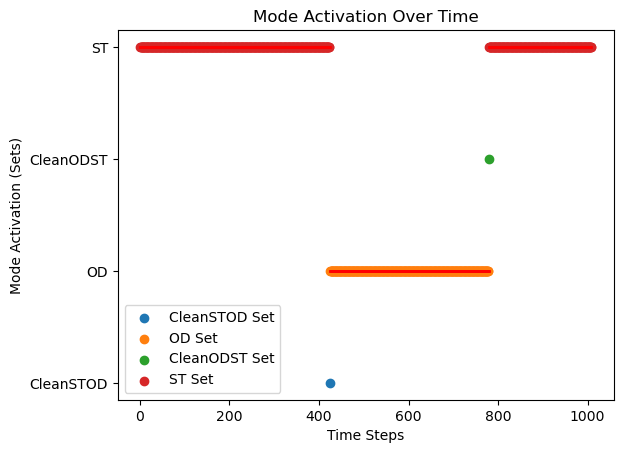

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the data provided
# time_steps = [1, 2, 3, 4, 5, 6, 7, 8]
# modes = ['M1', 'M2', 'M3', 'M4']

time_steps = list(T)
modes = list(M)

# Data for active modes at each time step
d = {}
for b in m.T:
    for a in m.M:
        if (pe.value(m.y[a,b])==1):
           # print('for mode',a, 'Time',b, 'val is',1)
            d[b] = a

active_modes = d.values()
active_modes = list(active_modes)

#active_modes = ['M1', 'M1', 'M2', 'M1', 'M3', 'M3', 'M4', 'M4']

# Create a plot with integers on y-axis and active lines
mode_dict = {mode: i for i, mode in enumerate(modes)}

for mode in modes:
    mode_values = [mode_dict[mode] if m == mode else np.nan for m in active_modes]
    plt.scatter(time_steps, mode_values, label=f'{mode} Set', marker='o')

# Plot active lines for each mode
for i in range(len(time_steps) - 1):
    active_mode = active_modes[i]
    active_index = mode_dict[active_mode]
    plt.plot(time_steps[i:i+2], [active_index, active_index], color='r', linestyle='-', linewidth=2)

# Set y-axis labels
plt.yticks(range(len(modes)), modes)

# Set plot labels and legend
plt.xlabel('Time Steps')
plt.ylabel('Mode Activation (Sets)')
plt.title('Mode Activation Over Time')
plt.legend()

# Show the plot
plt.show()


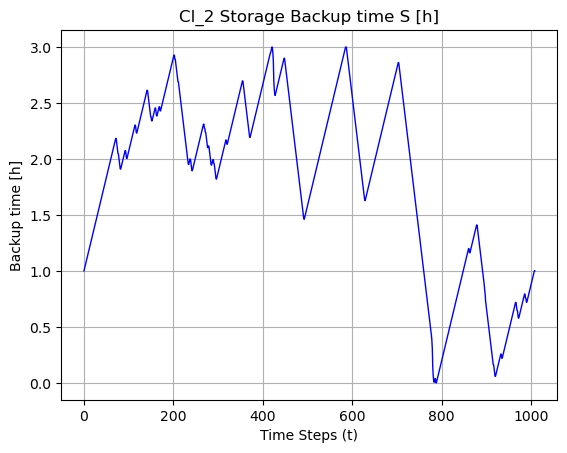

In [15]:
# Cl_2 Storage Backup time S [h] 
time_steps = list(T)
S_cl_values = [m.S_cl[t].value/3600 for t in m.T]

#S_cl_values = S_cl_values/3600

# Plotting
plt.plot(time_steps, S_cl_values, linestyle='-', color='b', linewidth=1)
plt.title('Cl_2 Storage Backup time S [h]')
plt.xlabel('Time Steps (t)')
plt.ylabel('Backup time [h]')

plt.grid(True)
plt.show()

In [16]:
# Cl_2 Production [t/h] [h] 

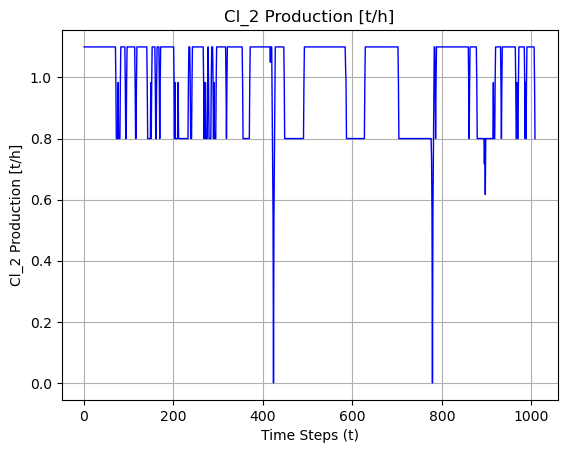

In [17]:
time_steps = list(T)
rate_cl2_prod = [m.mDot_cl2[t].value*3600/1000 for t in m.T]

# Plotting
plt.plot(time_steps, rate_cl2_prod, linestyle='-', color='b', linewidth=1)
plt.title('Cl_2 Production [t/h]')
plt.xlabel('Time Steps (t)')
plt.ylabel('Cl_2 Production [t/h]')
plt.grid(True)
plt.show()

In [35]:
# define expense as 0 for cl modes
# in el deamnd of cell, define m-dot-cl2,e = 0 for cleaning modes

In [36]:
for a in m.M:
    for b in m.M:
        for t in m.T_minassure:
            if (pe.value(m.z[a,b,t])==1):
                print("z val for",a,b,'at',t,"is",1)

z val for OD CleanODST at 103 is 1
z val for CleanODST ST at 104 is 1


In [ ]:
# conda install -c conda-forge coincbc

In [ ]:
# Check Final: All dimensions w.t.t. mass and time

In [ ]:
# m.mDot_cl2

In [ ]:
# Define reln b/w

# m.mDot_cm and m.mDot_cl2[m,t]   # constraints in process model.

In [1]:
# stuff to do 
# :morgan form sign
# :
#     define default params as zero wherever needed
#     add other explicit constraints 
#     such as:

#         The initial backup time of the Cl2 storage tank is assumed to satisfy
#         a downstream Cl2 demand of 1 h via SCl2,t=0 =1h=SCl2,tn. - Done
        
#         used in model where ? - only thing left
#         The Cl2 production is normalized to a production of m_ N, Cl2 = 1 tCl2 =h.
#         Therefore, this amount is continuously
#         taken out of the Cl2 storage tank.
        
#         used in model where ? - Done
#         The production can only be switched to the cleaning mode when the production rate is at its nonzero minimum 
#         m_dot_cl2 undebar

#         Define self transitions and other DAL transitions variables to be zero: DAL: disallowes transitions

In [513]:
a = set(range(-35, len(time_values) + 1))
print(a)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1}
